# Student Performance Prediction

This notebook implements six machine learning algorithms to predict student exam scores based on various factors including study hours, attendance, parental involvement, and other academic indicators.

## Algorithms Used:

### Traditional Machine Learning (3):
1. Linear Regression
2. Support Vector Regression (SVR)
3. Gradient Boosting Regressor

### Deep Learning (3):
4. Wide & Deep Neural Network
5. ResNet (Residual Network)
6. Bayesian Neural Network

## Dataset Features:
- Hours_Studied, Attendance, Parental_Involvement, Access_to_Resources
- Extracurricular_Activities, Sleep_Hours, Previous_Scores, Motivation_Level
- Internet_Access, Tutoring_Sessions, Family_Income, Teacher_Quality
- School_Type, Peer_Influence, Physical_Activity, Learning_Disabilities
- Parental_Education_Level, Distance_from_Home, Gender
- **Target Variable**: Exam_Score

## 1. Import Required Libraries

In [138]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set color palette
colors = ['#FF69B4', '#DDA0DD', '#87CEEB', '#FFB6C1', '#E6E6FA', '#B19CD9']
plt.style.use('default')
sns.set_palette(colors)

## 2. Load and Explore the Dataset

In [139]:
# Load the dataset
df = pd.read_csv('StudentPerformanceFactors.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (6607, 20)

First 5 rows:
   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessions Family_I

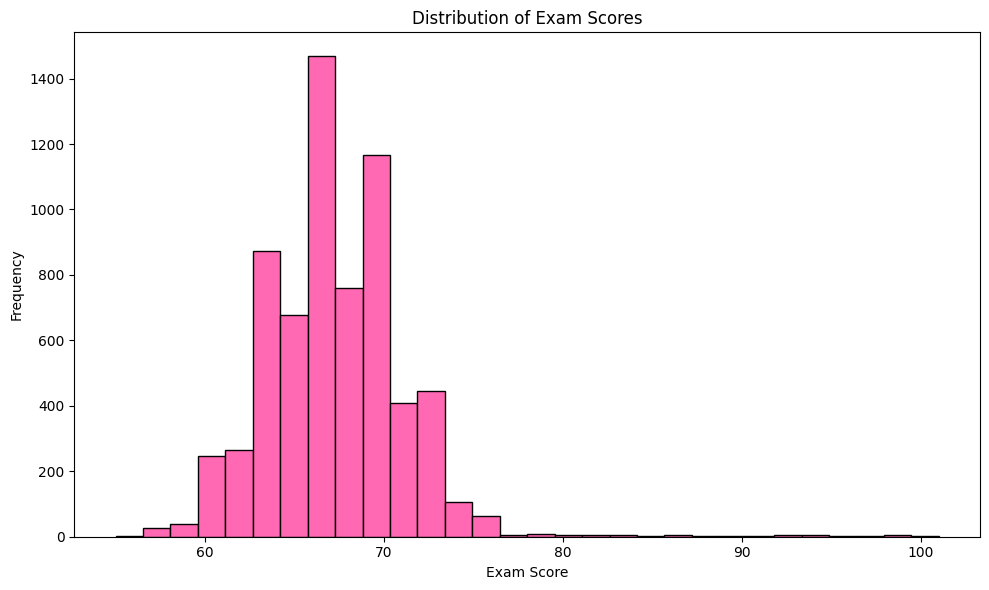

Exam Score Statistics:
Mean: 67.24
Median: 67.00
Standard Deviation: 3.89
Min: 55
Max: 101


In [140]:
# Visualize target variable distribution
plt.figure(figsize=(10, 6))
plt.hist(df['Exam_Score'], bins=30, edgecolor='black')
plt.title('Distribution of Exam Scores')
plt.xlabel('Exam Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('01_exam_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Exam Score Statistics:")
print(f"Mean: {df['Exam_Score'].mean():.2f}")
print(f"Median: {df['Exam_Score'].median():.2f}")
print(f"Standard Deviation: {df['Exam_Score'].std():.2f}")
print(f"Min: {df['Exam_Score'].min()}")
print(f"Max: {df['Exam_Score'].max()}")

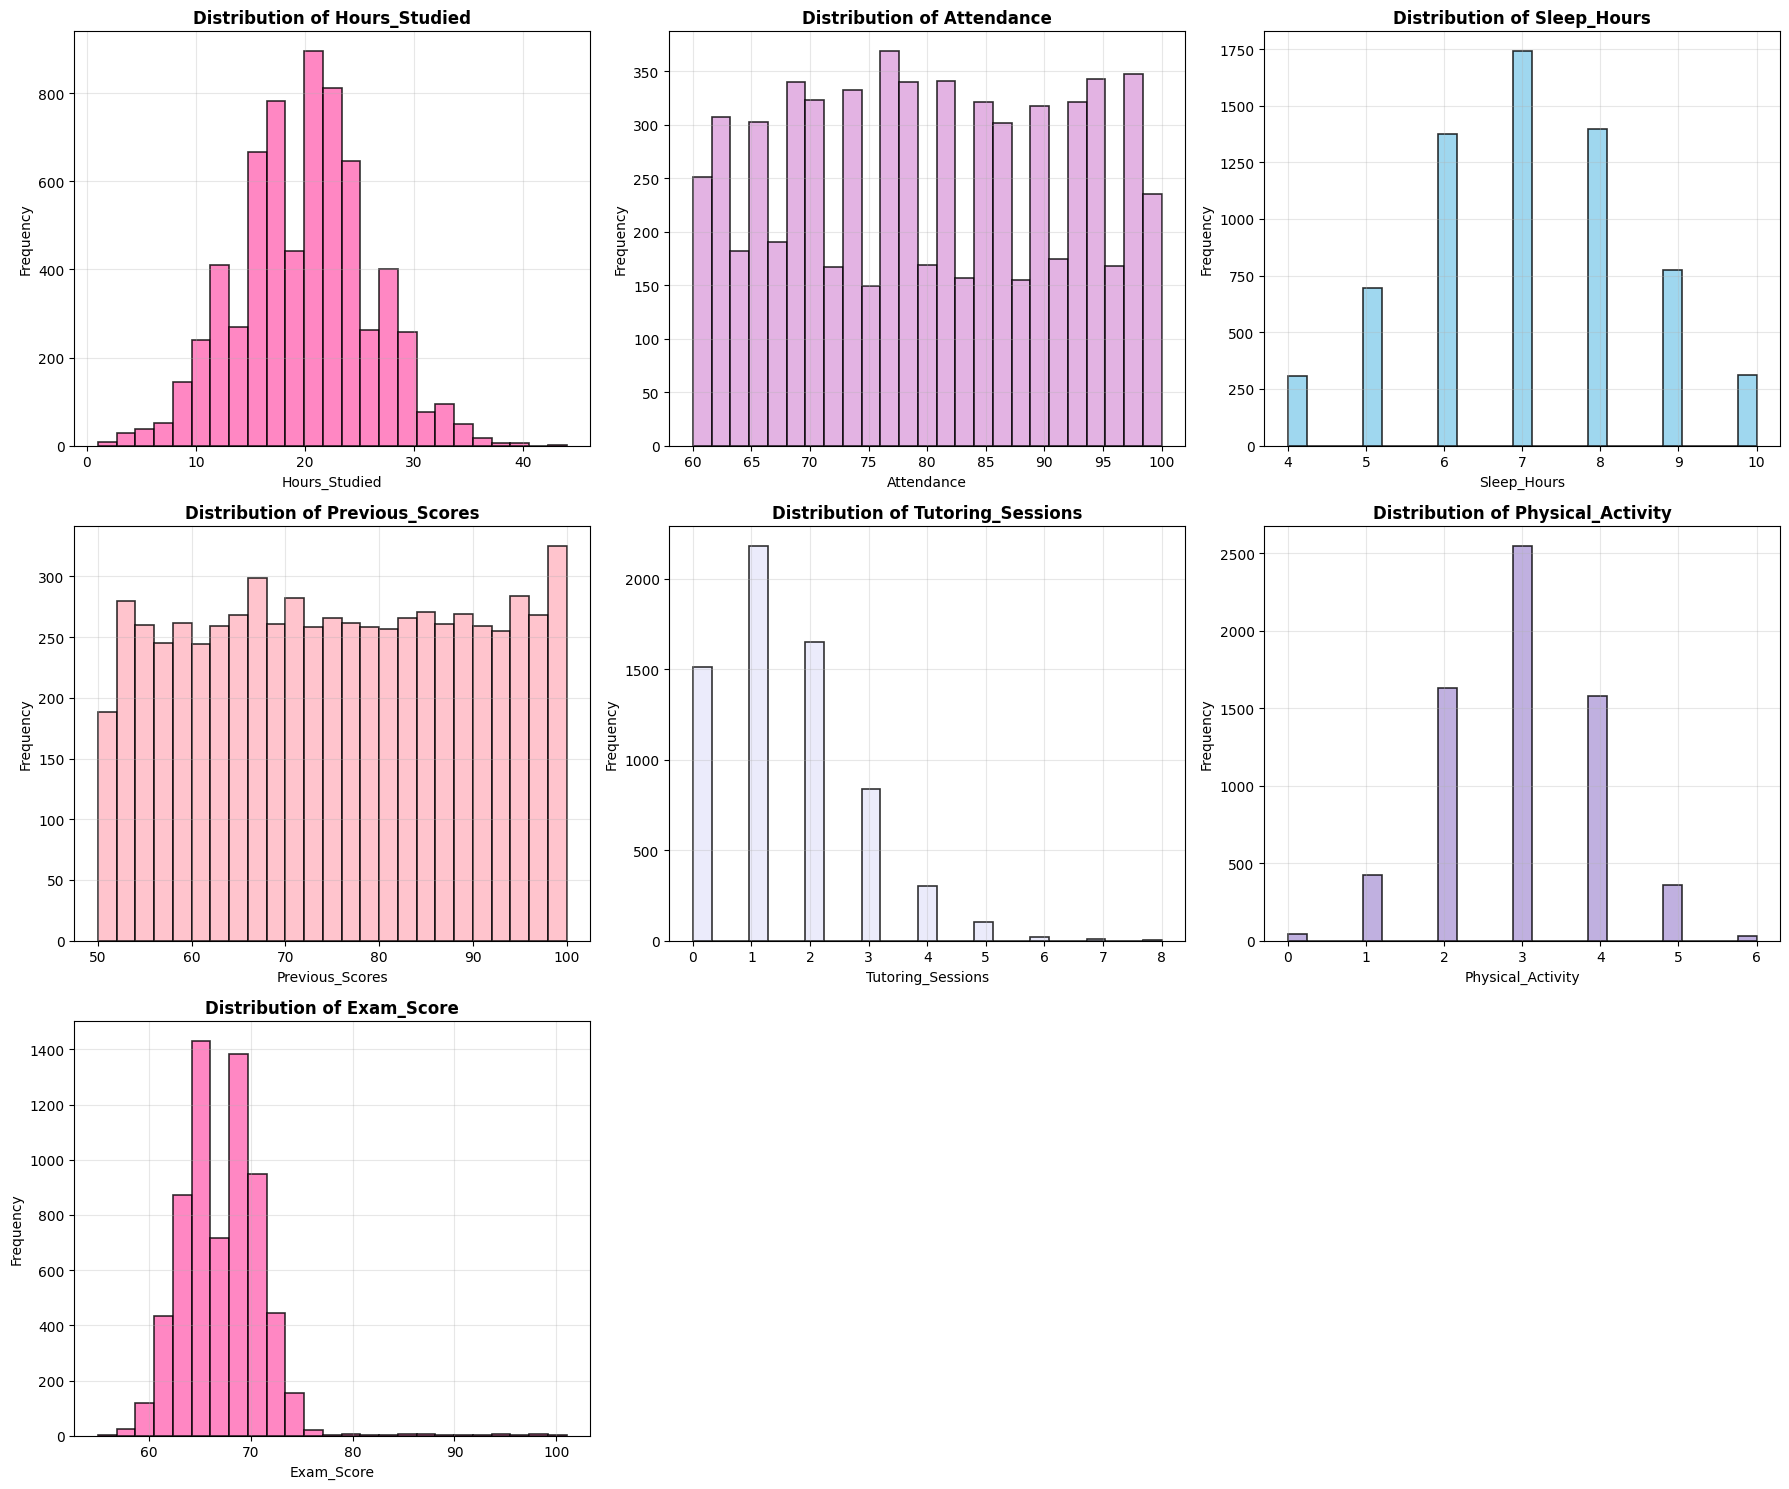

In [141]:
# Set color palette
colors = ['#FF69B4', '#DDA0DD', '#87CEEB', '#FFB6C1', '#E6E6FA', '#B19CD9']
sns.set_palette(colors)

# Exploratory Data Analysis - Numerical Variables
numerical_cols = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores',
                 'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score']

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    axes[i].hist(df[col], bins=25, color=colors[i % len(colors)],
                alpha=0.8, edgecolor='black', linewidth=1.2)
    axes[i].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

# Hide the extra subplots
for i in range(len(numerical_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig('02_numerical_variables_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

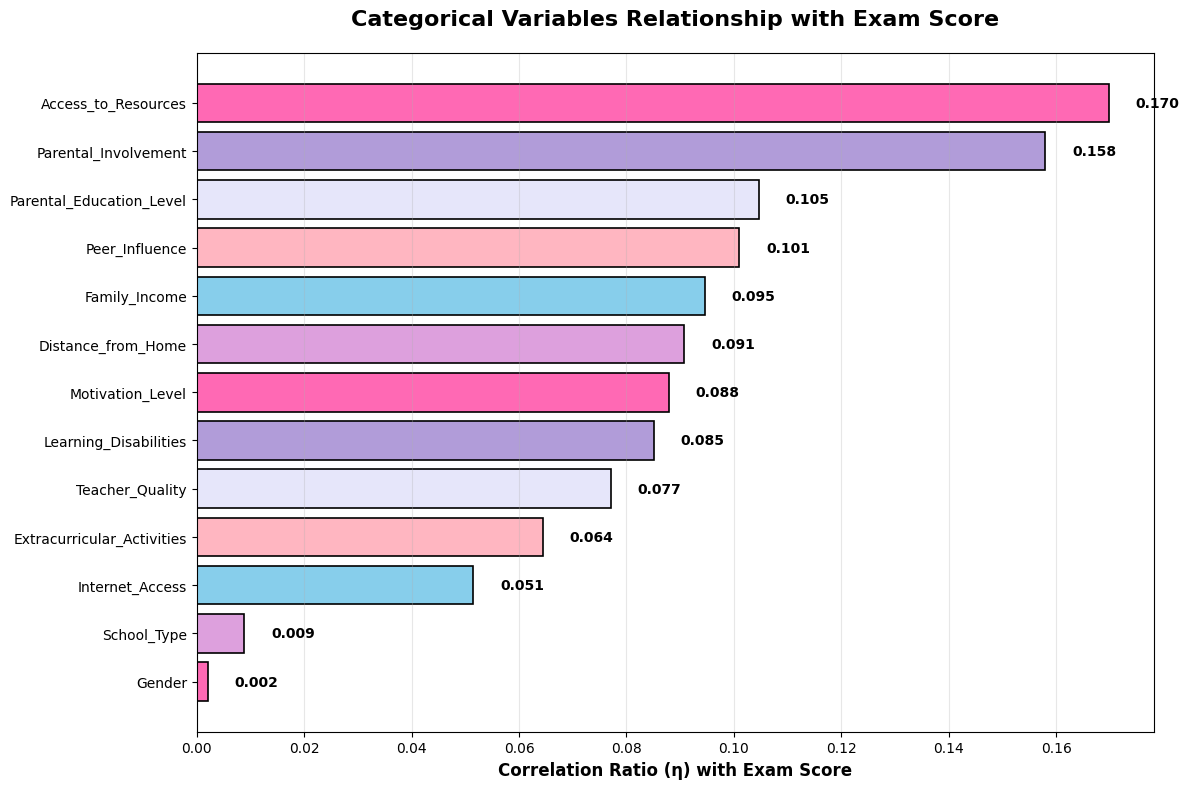

Correlation Ratio (η) ranges from 0 (no relationship) to 1 (perfect relationship)
Higher values indicate stronger relationship between categorical variable and Exam Score

Top 5 categorical variables most related to Exam Score:
    Categorical_Variable  Correlation_with_Exam_Score
           Family_Income                     0.094564
          Peer_Influence                     0.101031
Parental_Education_Level                     0.104663
    Parental_Involvement                     0.157951
     Access_to_Resources                     0.169779


In [142]:
# Define categorical columns
categorical_columns = ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                      'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                      'School_Type', 'Peer_Influence', 'Learning_Disabilities',
                      'Parental_Education_Level', 'Distance_from_Home', 'Gender']

categorical_cols = categorical_columns.copy()

# Cramér's V calculation for categorical associations
def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Import scipy.stats for chi2_contingency
from scipy import stats

# Create categorical association matrix using Cramér's V
categorical_association = pd.DataFrame(np.zeros((len(categorical_columns), len(categorical_columns))),
                                     index=categorical_columns, columns=categorical_columns)

for i, col1 in enumerate(categorical_columns):
    for j, col2 in enumerate(categorical_columns):
        if i == j:
            categorical_association.loc[col1, col2] = 1.0
        elif i < j:
            cramers = cramers_v(df[col1], df[col2])
            categorical_association.loc[col1, col2] = cramers
            categorical_association.loc[col2, col1] = cramers

# Calculate correlation ratio (eta) for categorical vs numerical
def correlation_ratio(categories, values):
    """Calculate correlation ratio (eta) between categorical and numerical variables."""
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)

    for i in range(0, cat_num):
        cat_measures = values[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)

    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    numerator = np.sum(np.multiply(n_array, np.power(np.subtract(y_avg_array, y_total_avg), 2)))
    denominator = np.sum(np.power(np.subtract(values, y_total_avg), 2))

    if denominator == 0:
        return 0
    else:
        return np.sqrt(numerator / denominator)

# Calculate correlation ratio for each categorical variable with Exam_Score
cat_exam_correlations = {}
for col in categorical_columns:
    eta = correlation_ratio(df[col], df['Exam_Score'])
    cat_exam_correlations[col] = eta

# Visualize categorical-exam score relationships
cat_corr_df = pd.DataFrame(list(cat_exam_correlations.items()),
                          columns=['Categorical_Variable', 'Correlation_with_Exam_Score'])
cat_corr_df = cat_corr_df.sort_values('Correlation_with_Exam_Score', ascending=True)

plt.figure(figsize=(12, 8))
bars = plt.barh(cat_corr_df['Categorical_Variable'], cat_corr_df['Correlation_with_Exam_Score'],
               color=colors * 3, edgecolor='black', linewidth=1.2)

plt.xlabel('Correlation Ratio (η) with Exam Score', fontweight='bold', fontsize=12)
plt.title('Categorical Variables Relationship with Exam Score',
          fontweight='bold', fontsize=16, pad=20)
plt.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('03_categorical_exam_score_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("Correlation Ratio (η) ranges from 0 (no relationship) to 1 (perfect relationship)")
print("Higher values indicate stronger relationship between categorical variable and Exam Score")
print("\nTop 5 categorical variables most related to Exam Score:")
print(cat_corr_df.tail().to_string(index=False))

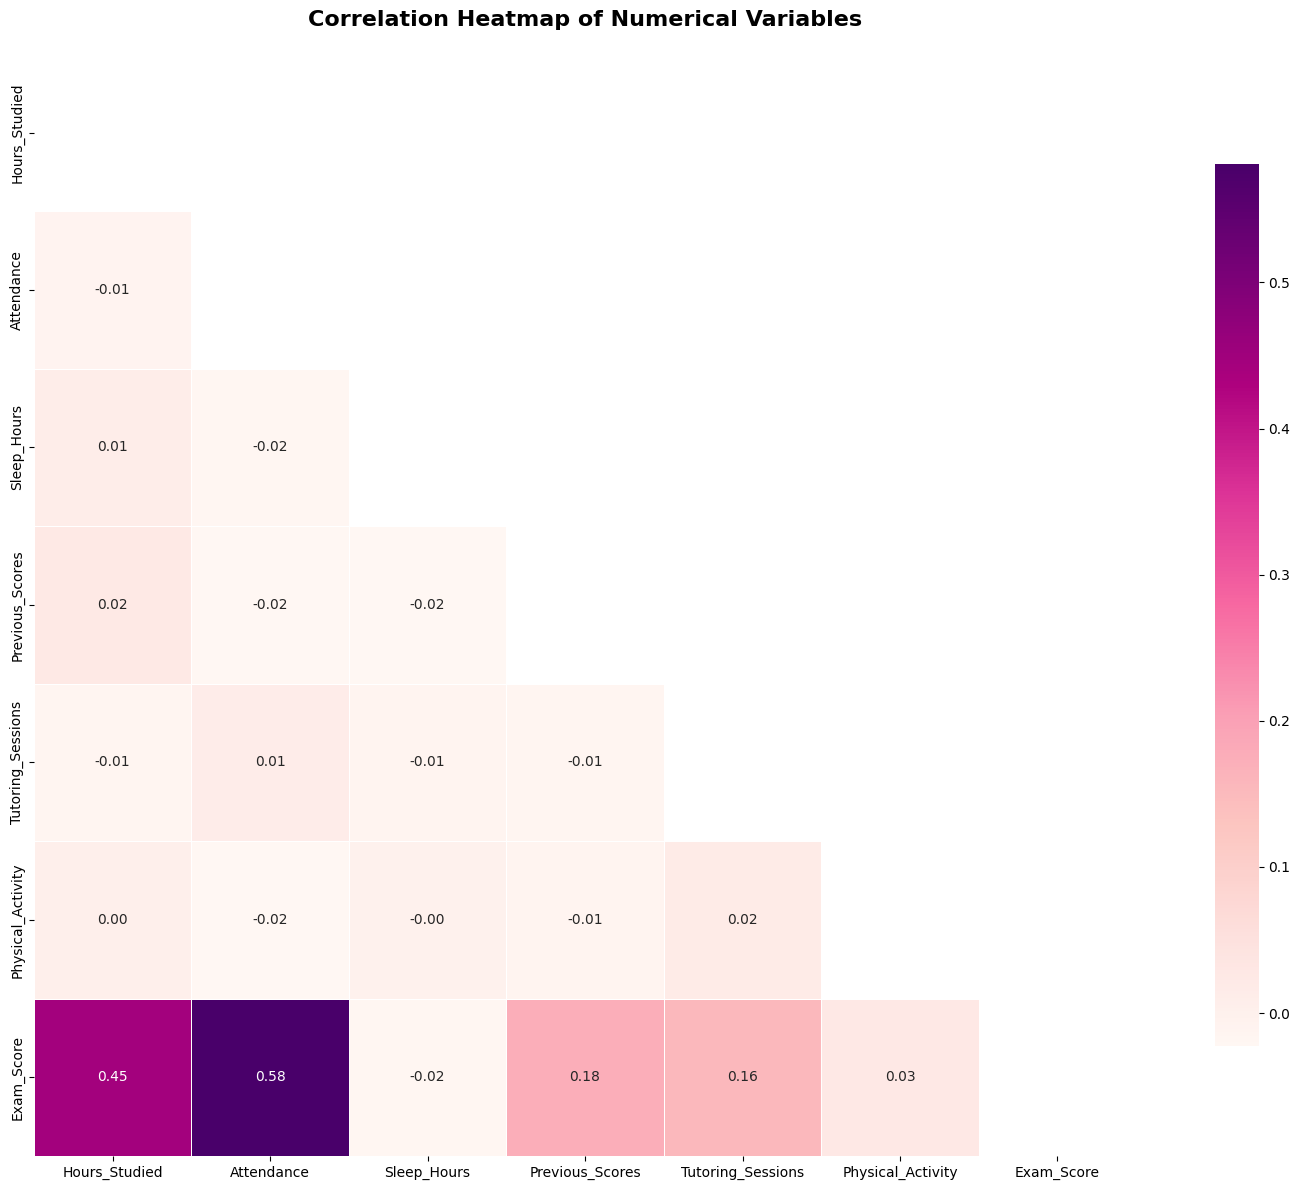

Strongest correlations with Exam Score:
Attendance           0.581072
Hours_Studied        0.445455
Previous_Scores      0.175079
Tutoring_Sessions    0.156525
Physical_Activity    0.027824
Sleep_Hours          0.017022
Name: Exam_Score, dtype: float64


In [143]:
# Correlation Heatmap
plt.figure(figsize=(16, 12))

# Calculate correlation matrix for numerical variables only
numerical_df = df[numerical_cols]
correlation_matrix = numerical_df.corr()

# Create heatmap with feminine colors
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdPu',
            square=True, linewidths=0.5, cbar_kws={"shrink": .8},
            fmt='.2f', annot_kws={'size': 10})

plt.title('Correlation Heatmap of Numerical Variables', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('04_numerical_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Show strongest correlations with Exam_Score
exam_correlations = correlation_matrix['Exam_Score'].abs().sort_values(ascending=False)
print("Strongest correlations with Exam Score:")
print(exam_correlations[1:].head(10))  # Exclude self-correlation

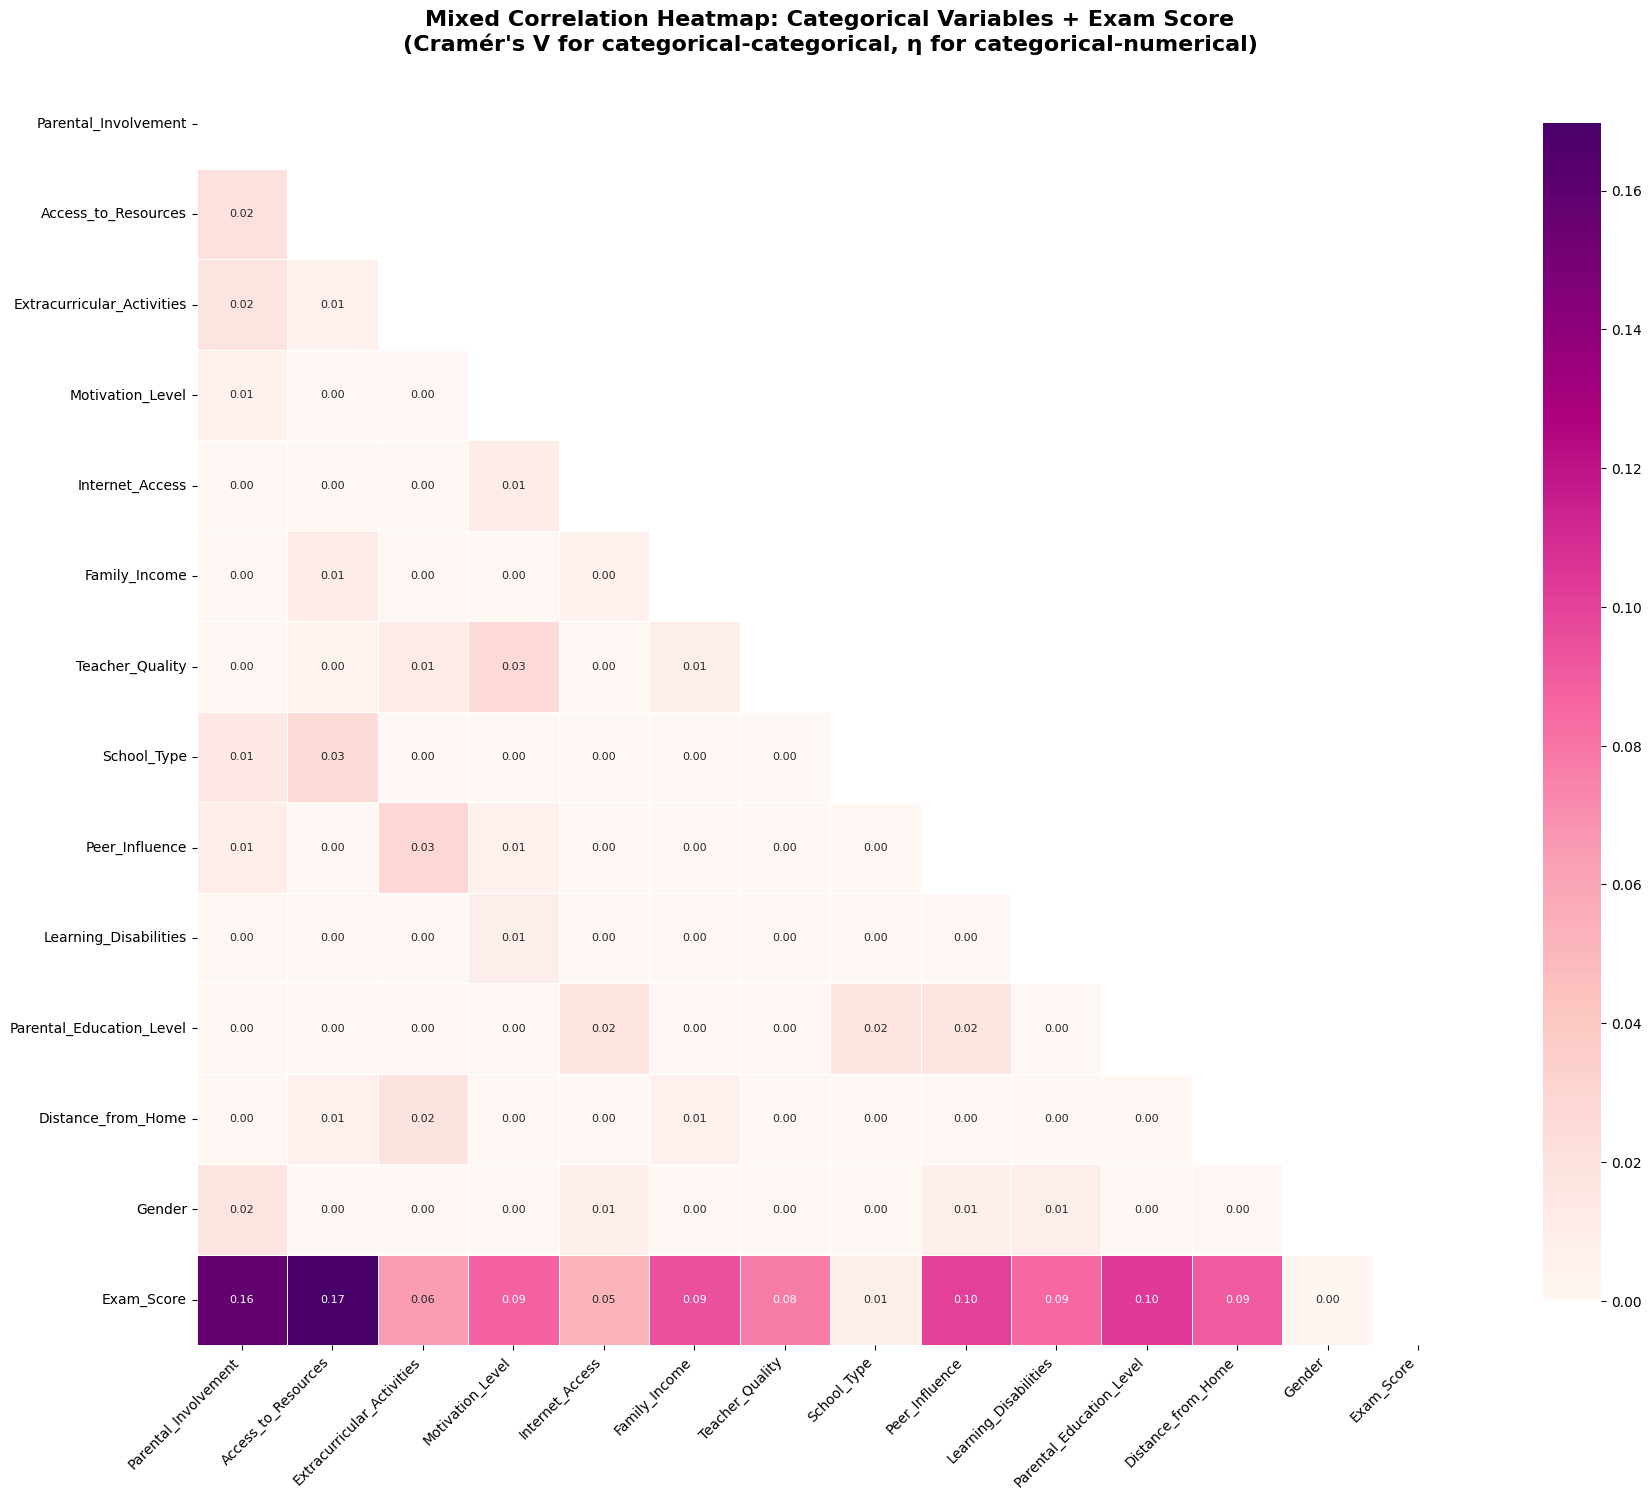

Mixed Correlation Matrix Legend:
• Cramér's V (categorical ↔ categorical): 0 = no association, 1 = perfect association
• Correlation Ratio η (categorical ↔ Exam_Score): 0 = no relationship, 1 = perfect relationship
• Values > 0.3 indicate moderate to strong relationships


In [144]:
# Create Mixed Correlation Matrix: Categorical Variables + Exam Score
# Combines Cramér's V (categorical-categorical) with Correlation Ratio (categorical-numerical)

# Start with the categorical association matrix
mixed_correlation = categorical_association.copy()

# Add Exam_Score as a new row and column
exam_score_col = 'Exam_Score'
mixed_correlation[exam_score_col] = 0.0
mixed_correlation.loc[exam_score_col] = 0.0

# Fill in the correlation ratios between categorical variables and Exam_Score
for col in categorical_cols:
    eta_value = cat_exam_correlations[col]
    mixed_correlation.loc[col, exam_score_col] = eta_value
    mixed_correlation.loc[exam_score_col, col] = eta_value

# Set Exam_Score self-correlation to 1
mixed_correlation.loc[exam_score_col, exam_score_col] = 1.0

# Create the mixed heatmap
plt.figure(figsize=(18, 16))
mask = np.triu(np.ones_like(mixed_correlation, dtype=bool))
sns.heatmap(mixed_correlation, mask=mask, annot=True, cmap='RdPu',
            square=True, linewidths=0.5, cbar_kws={"shrink": .8},
            fmt='.2f', annot_kws={'size': 8})

plt.title('Mixed Correlation Heatmap: Categorical Variables + Exam Score\n(Cramér\'s V for categorical-categorical, η for categorical-numerical)',
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('05_mixed_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Mixed Correlation Matrix Legend:")
print("• Cramér's V (categorical ↔ categorical): 0 = no association, 1 = perfect association")
print("• Correlation Ratio η (categorical ↔ Exam_Score): 0 = no relationship, 1 = perfect relationship")
print("• Values > 0.3 indicate moderate to strong relationships")

## 3. Data Preprocessing and Feature Engineering

In [145]:
# Create a copy for preprocessing
df_processed = df.copy()

# Identify categorical and numerical columns
categorical_columns = ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                      'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                      'School_Type', 'Peer_Influence', 'Learning_Disabilities',
                      'Parental_Education_Level', 'Distance_from_Home', 'Gender']

numerical_columns = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores',
                    'Tutoring_Sessions', 'Physical_Activity']

print("Categorical columns:", categorical_columns)
print("Numerical columns:", numerical_columns)

# Check unique values in categorical columns
for col in categorical_columns:
    print(f"\n{col}: {df_processed[col].unique()}")

Categorical columns: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
Numerical columns: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']

Parental_Involvement: ['Low' 'Medium' 'High']

Access_to_Resources: ['High' 'Medium' 'Low']

Extracurricular_Activities: ['No' 'Yes']

Motivation_Level: ['Low' 'Medium' 'High']

Internet_Access: ['Yes' 'No']

Family_Income: ['Low' 'Medium' 'High']

Teacher_Quality: ['Medium' 'High' 'Low' nan]

School_Type: ['Public' 'Private']

Peer_Influence: ['Positive' 'Negative' 'Neutral']

Learning_Disabilities: ['No' 'Yes']

Parental_Education_Level: ['High School' 'College' 'Postgraduate' nan]

Distance_from_Home: ['Near' 'Moderate' 'Far' nan]

Gender: ['Male' 'Female']


In [146]:
# Label encode categorical variables
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le

# Separate features and target
X = df_processed.drop('Exam_Score', axis=1)
y = df_processed['Exam_Score']

# Scale numerical features
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_columns] = scaler.fit_transform(X[numerical_columns])

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nPreprocessed features preview:")
print(X_scaled.head())

Features shape: (6607, 19)
Target shape: (6607,)

Preprocessed features preview:
   Hours_Studied  Attendance  Parental_Involvement  Access_to_Resources  \
0       0.504942    0.348375                     1                    0   
1      -0.162822   -1.383736                     1                    2   
2       0.671882    1.560853                     2                    2   
3       1.506587    0.781403                     1                    2   
4      -0.162822    1.041220                     2                    2   

   Extracurricular_Activities  Sleep_Hours  Previous_Scores  Motivation_Level  \
0                           0    -0.019796        -0.143800                 1   
1                           0     0.661399        -1.116110                 1   
2                           1    -0.019796         1.106313                 2   
3                           1     0.661399         1.592469                 2   
4                           1    -0.700990        -0.699406    

## 4. Split Data into Training and Testing Sets

In [147]:
# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

# Create a dictionary to store model results
model_results = {}

Training set size: 5285 samples
Testing set size: 1322 samples
Features: 19


## 5. Linear Regression Model

Linear Regression Results:
RMSE: 2.098
MAE: 1.016
R² Score: 0.689
Accuracy (±2 points): 92.1%


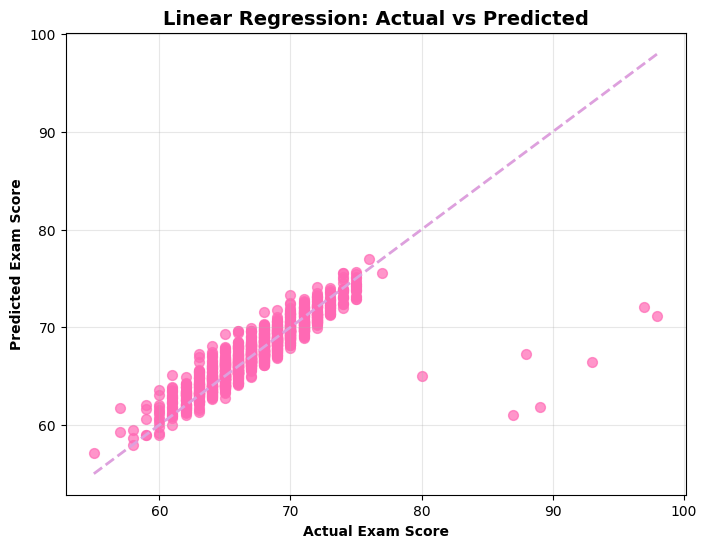

In [148]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test)

# Calculate metrics
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

# Calculate accuracy (within 2 points tolerance)
lr_accuracy = np.mean(np.abs(y_test - lr_pred) <= 2) * 100

# Store results
model_results['Linear Regression'] = {
    'RMSE': lr_rmse,
    'MAE': lr_mae,
    'R²': lr_r2,
    'Accuracy': lr_accuracy,
    'Predictions': lr_pred
}

print("Linear Regression Results:")
print(f"RMSE: {lr_rmse:.3f}")
print(f"MAE: {lr_mae:.3f}")
print(f"R² Score: {lr_r2:.3f}")
print(f"Accuracy (±2 points): {lr_accuracy:.1f}%")

# Plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, lr_pred, alpha=0.7, color='#FF69B4', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#DDA0DD', linestyle='--', lw=2)
plt.xlabel('Actual Exam Score', fontweight='bold')
plt.ylabel('Predicted Exam Score', fontweight='bold')
plt.title('Linear Regression: Actual vs Predicted', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig('06_linear_regression_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Support Vector Regression Model

Support Vector Regression Results:
RMSE: 1.843
MAE: 0.560
R² Score: 0.760
Accuracy (±2 points): 99.1%


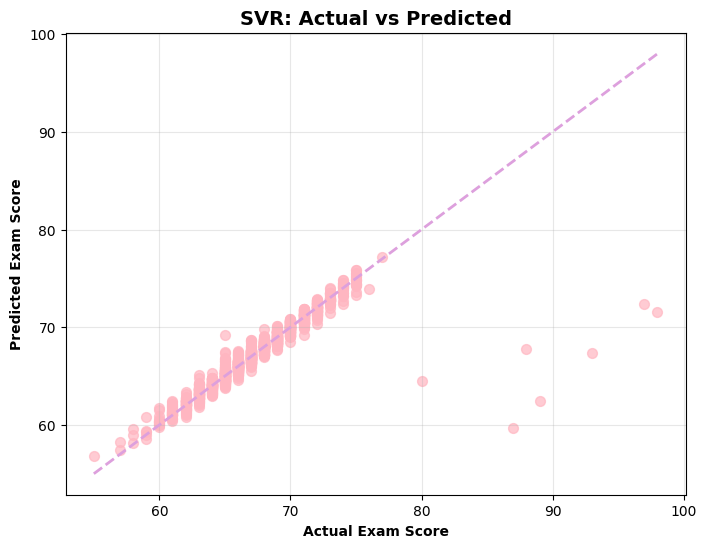

In [149]:
# Train Support Vector Regression model
svr_model = SVR(kernel='rbf', C=100, gamma='scale')
svr_model.fit(X_train, y_train)

# Make predictions
svr_pred = svr_model.predict(X_test)

# Calculate metrics
svr_rmse = np.sqrt(mean_squared_error(y_test, svr_pred))
svr_mae = mean_absolute_error(y_test, svr_pred)
svr_r2 = r2_score(y_test, svr_pred)

# Calculate accuracy (within 2 points tolerance)
svr_accuracy = np.mean(np.abs(y_test - svr_pred) <= 2) * 100

# Store results
model_results['SVR'] = {
    'RMSE': svr_rmse,
    'MAE': svr_mae,
    'R²': svr_r2,
    'Accuracy': svr_accuracy,
    'Predictions': svr_pred
}

print("Support Vector Regression Results:")
print(f"RMSE: {svr_rmse:.3f}")
print(f"MAE: {svr_mae:.3f}")
print(f"R² Score: {svr_r2:.3f}")
print(f"Accuracy (±2 points): {svr_accuracy:.1f}%")

# Plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, svr_pred, alpha=0.7, color='#FFB6C1', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#DDA0DD', linestyle='--', lw=2)
plt.xlabel('Actual Exam Score', fontweight='bold')
plt.ylabel('Predicted Exam Score', fontweight='bold')
plt.title('SVR: Actual vs Predicted', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig('08_svr_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Gradient Boosting Regressor Model

Gradient Boosting Results:
RMSE: 1.949
MAE: 0.824
R² Score: 0.731
Accuracy (±2 points): 95.8%


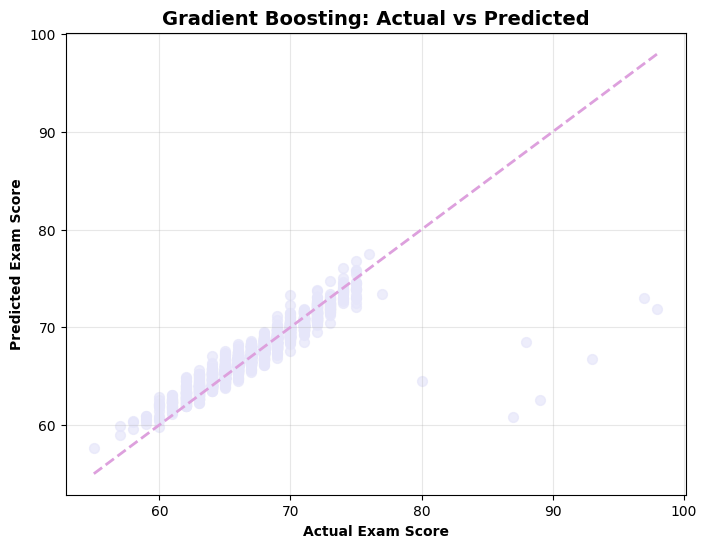

In [150]:
# Train Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
gb_pred = gb_model.predict(X_test)

# Calculate metrics
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)

# Calculate accuracy (within 2 points tolerance)
gb_accuracy = np.mean(np.abs(y_test - gb_pred) <= 2) * 100

# Store results
model_results['Gradient Boosting'] = {
    'RMSE': gb_rmse,
    'MAE': gb_mae,
    'R²': gb_r2,
    'Accuracy': gb_accuracy,
    'Predictions': gb_pred
}

print("Gradient Boosting Results:")
print(f"RMSE: {gb_rmse:.3f}")
print(f"MAE: {gb_mae:.3f}")
print(f"R² Score: {gb_r2:.3f}")
print(f"Accuracy (±2 points): {gb_accuracy:.1f}%")

# Plot predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, gb_pred, alpha=0.7, color='#E6E6FA', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#DDA0DD', linestyle='--', lw=2)
plt.xlabel('Actual Exam Score', fontweight='bold')
plt.ylabel('Predicted Exam Score', fontweight='bold')
plt.title('Gradient Boosting: Actual vs Predicted', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig('09_gradient_boosting_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Model Comparison and Evaluation

Model Comparison:
               Model   RMSE    MAE     R²  Accuracy (%)
1                SVR  1.843  0.560  0.760        99.092
2  Gradient Boosting  1.949  0.824  0.731        95.764
0  Linear Regression  2.098  1.016  0.689        92.057


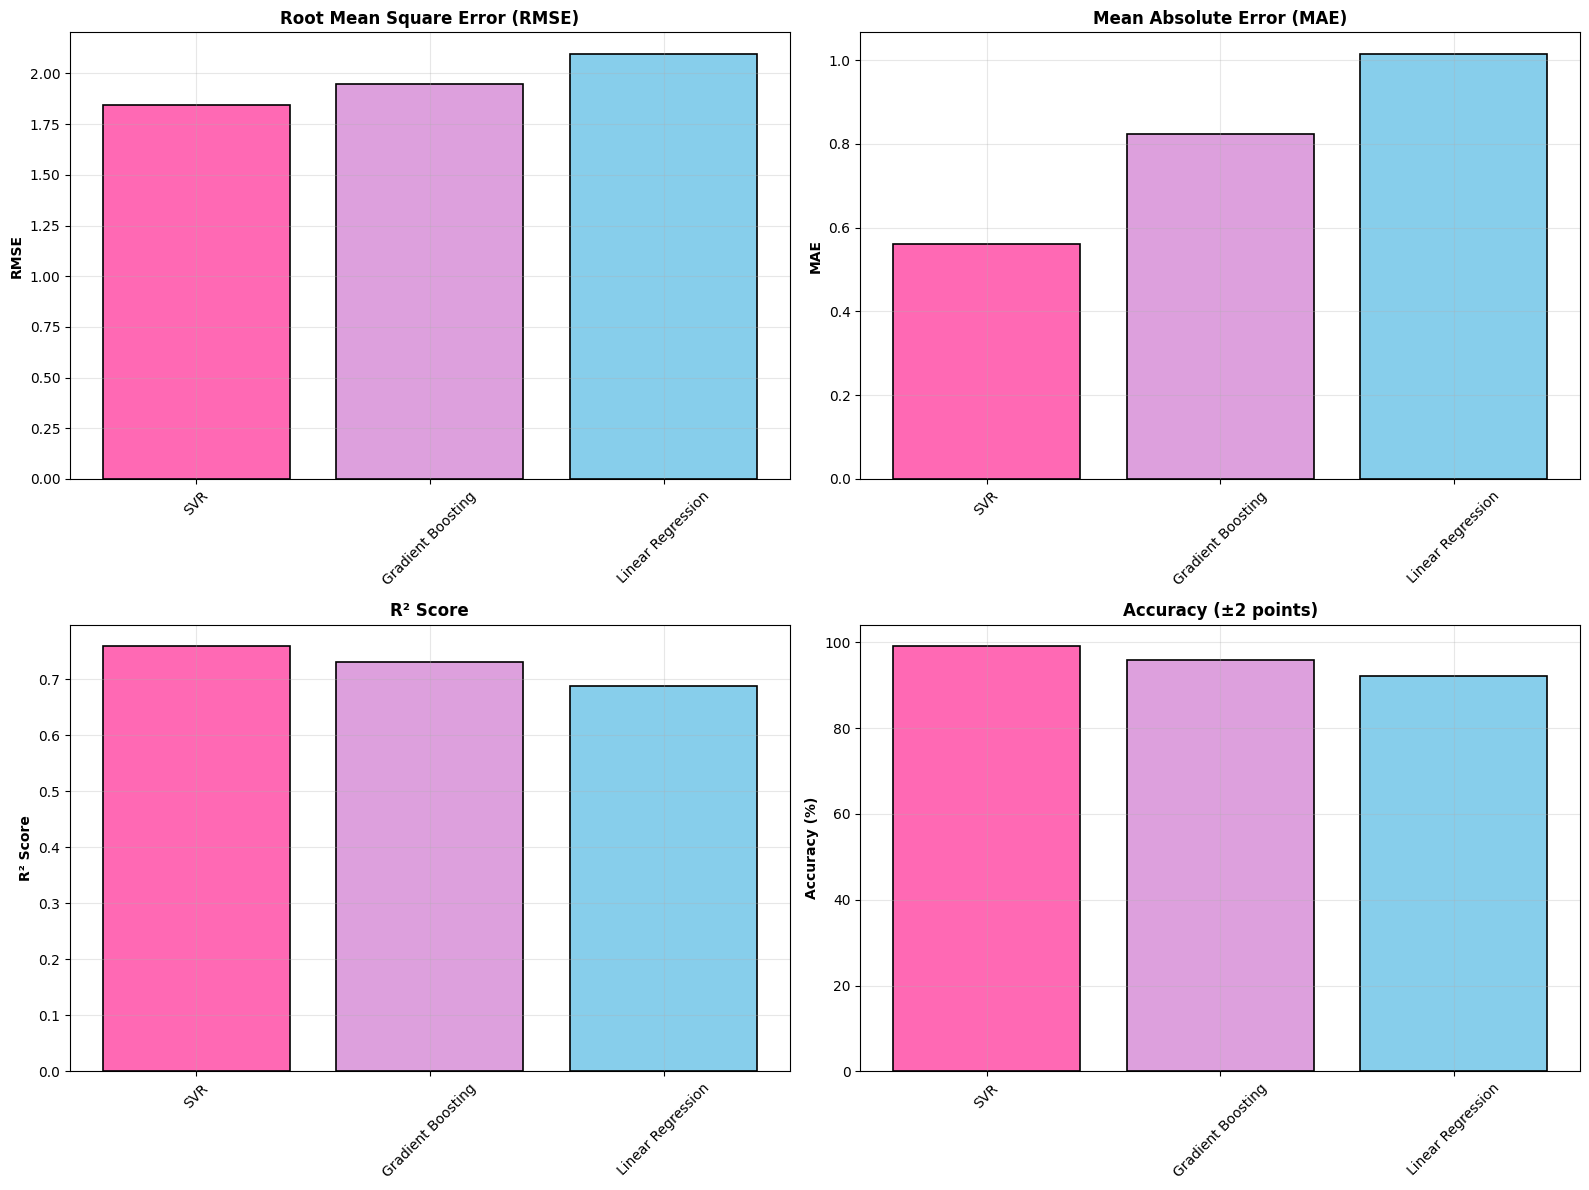

Accuracy: 99.1%

Best performing model: SVR
R² Score: 0.760


In [151]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'RMSE': [model_results[model]['RMSE'] for model in model_results.keys()],
    'MAE': [model_results[model]['MAE'] for model in model_results.keys()],
    'R²': [model_results[model]['R²'] for model in model_results.keys()],
    'Accuracy (%)': [model_results[model]['Accuracy'] for model in model_results.keys()]
})

# Sort by R² score (descending)
comparison_df = comparison_df.sort_values('R²', ascending=False)

print("Model Comparison:")
print(comparison_df.round(3))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RMSE comparison
axes[0,0].bar(comparison_df['Model'], comparison_df['RMSE'], color=colors[:len(comparison_df)],
             edgecolor='black', linewidth=1.2, width=0.8)
axes[0,0].set_title('Root Mean Square Error (RMSE)', fontweight='bold', fontsize=12)
axes[0,0].set_ylabel('RMSE', fontweight='bold')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# MAE comparison
axes[0,1].bar(comparison_df['Model'], comparison_df['MAE'], color=colors[:len(comparison_df)],
             edgecolor='black', linewidth=1.2, width=0.8)
axes[0,1].set_title('Mean Absolute Error (MAE)', fontweight='bold', fontsize=12)
axes[0,1].set_ylabel('MAE', fontweight='bold')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# R² comparison
axes[1,0].bar(comparison_df['Model'], comparison_df['R²'], color=colors[:len(comparison_df)],
             edgecolor='black', linewidth=1.2, width=0.8)
axes[1,0].set_title('R² Score', fontweight='bold', fontsize=12)
axes[1,0].set_ylabel('R² Score', fontweight='bold')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1,1].bar(comparison_df['Model'], comparison_df['Accuracy (%)'], color=colors[:len(comparison_df)],
             edgecolor='black', linewidth=1.2, width=0.8)
axes[1,1].set_title('Accuracy (±2 points)', fontweight='bold', fontsize=12)
axes[1,1].set_ylabel('Accuracy (%)', fontweight='bold')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('10_model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Find best model
best_model = comparison_df.iloc[0]['Model']
print(f"Accuracy: {comparison_df.iloc[0]['Accuracy (%)']:.1f}%")

print(f"\nBest performing model: {best_model}")
print(f"R² Score: {comparison_df.iloc[0]['R²']:.3f}")

## 10. Feature Importance Analysis

Gradient Boosting Feature Importance:
                     Feature  Importance
1                 Attendance    0.466821
0              Hours_Studied    0.284031
6            Previous_Scores    0.050061
3        Access_to_Resources    0.039368
2       Parental_Involvement    0.038202
9          Tutoring_Sessions    0.036430
13            Peer_Influence    0.013550
10             Family_Income    0.012589
16  Parental_Education_Level    0.009252
7           Motivation_Level    0.008658


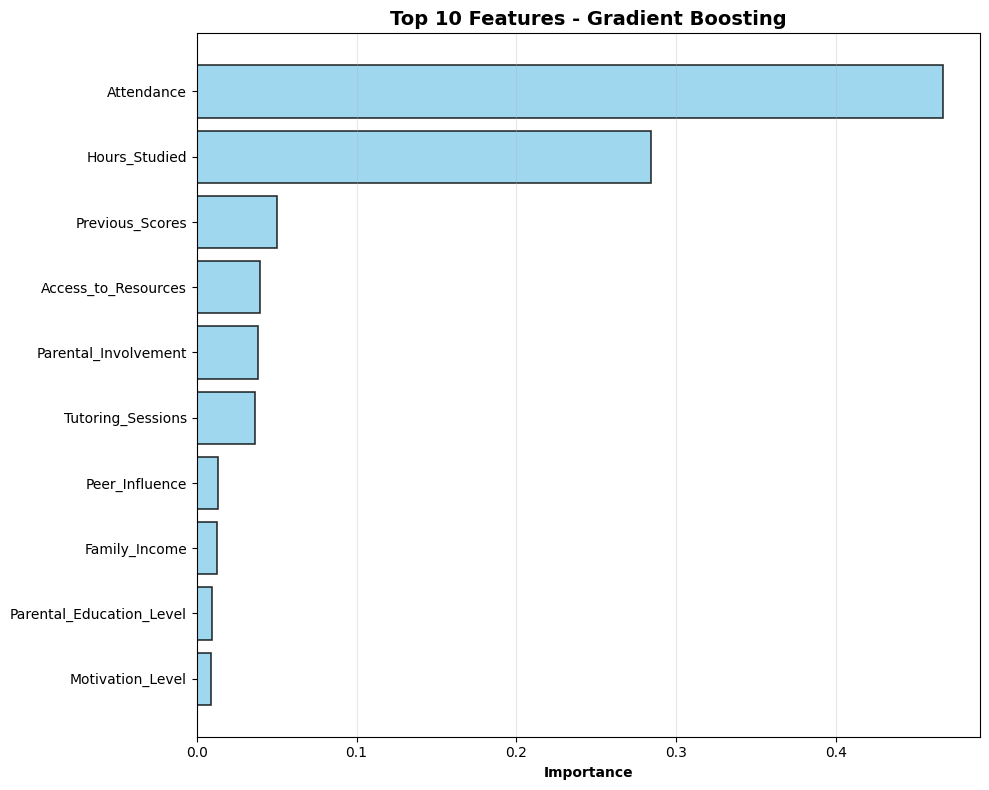

In [152]:
# Feature importance from Gradient Boosting
feature_importance_gb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Gradient Boosting Feature Importance:")
print(feature_importance_gb.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))

bars = plt.barh(feature_importance_gb.head(10)['Feature'][::-1],
                feature_importance_gb.head(10)['Importance'][::-1],
                color='#87CEEB', alpha=0.8, edgecolor='black', linewidth=1.2)
plt.title('Top 10 Features - Gradient Boosting', fontweight='bold', fontsize=14)
plt.xlabel('Importance', fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('11_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## Conclusion

This notebook demonstrated the implementation of six machine learning algorithms to predict student exam scores:

### Traditional Machine Learning (3):
1. **Linear Regression**: Simple baseline model with linear relationships
2. **Support Vector Regression**: Non-linear regression with RBF kernel for complex patterns
3. **Gradient Boosting Regressor**: Sequential ensemble method for improved accuracy

### Deep Learning (3):
4. **Wide & Deep Neural Network**: Combines memorization (wide path) with generalization (deep path)
5. **ResNet (Residual Network)**: Uses skip connections to enable deeper networks and better gradient flow
6. **Bayesian Neural Network**: Provides probabilistic predictions with uncertainty quantification

## 📊 Final Model Performance Summary

# Deep Learning Models Comparison

The following section compares the 3 Deep Learning models implemented:
- Wide & Deep Neural Network
- ResNet (Residual Network)
- Bayesian Neural Network

# Wide and Deep Model
Deep Learning Model Comparison

In [153]:
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Data Preparation
df_wd = pd.read_csv('StudentPerformanceFactors.csv')
df_wd = df_wd.dropna(subset=['Exam_Score'])

X = df_wd.drop('Exam_Score', axis=1)
y = df_wd['Exam_Score']

# Standard preprocessing
numeric_features = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']
categorical_features = [col for col in X.columns if col not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_processed = preprocessor.fit_transform(X)

# Fix sparse matrix
if hasattr(X_processed, 'toarray'):
    X_processed = X_processed.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Wide & Deep Architecture
input_layer = Input(shape=(X_train.shape[1],), name='input_features')

# Deep path - for complex patterns
deep_path = Dense(64, activation='relu')(input_layer)
deep_path = Dropout(0.3)(deep_path)
deep_path = Dense(32, activation='relu')(deep_path)
deep_path = Dropout(0.2)(deep_path)

# Wide path - for linear memorization
wide_path = Dense(16, activation='linear')(input_layer)

# Combine both paths
combined = Concatenate()([deep_path, wide_path])

# Final prediction layer
output_layer = Dense(1, activation='linear', name='final_score')(combined)

# Create the model
model_wd = Model(inputs=input_layer, outputs=output_layer)

# Compilation and Training
model_wd.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mean_squared_error',
                 metrics=['mae'])

print("--- Training Wide & Deep Model ---")
history_wd = model_wd.fit(X_train, y_train,
                          validation_data=(X_test, y_test),
                          epochs=100,
                          batch_size=32,
                          verbose=0)

# Evaluation
loss, mae = model_wd.evaluate(X_test, y_test, verbose=0)
print(f"\nWide & Deep Results:")
print(f"MAE: {mae:.3f}")

# Sample predictions
preds = model_wd.predict(X_test[:3])
print(f"\nPredictions (Wide & Deep) vs Reality:")
for i in range(3):
    print(f"Predicted: {preds[i][0]:.1f} | Real: {y_test.iloc[i]}")

--- Training Wide & Deep Model ---

Wide & Deep Results:
MAE: 0.475
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Wide & Deep Results:
MAE: 0.475
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

Predictions (Wide & Deep) vs Reality:
Predicted: 64.5 | Real: 65
Predicted: 65.0 | Real: 65
Predicted: 71.0 | Real: 71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

Predictions (Wide & Deep) vs Reality:
Predicted: 64.5 | Real: 65
Predicted: 65.0 | Real: 65
Predicted: 71.0 | Real: 71


## Loss Function

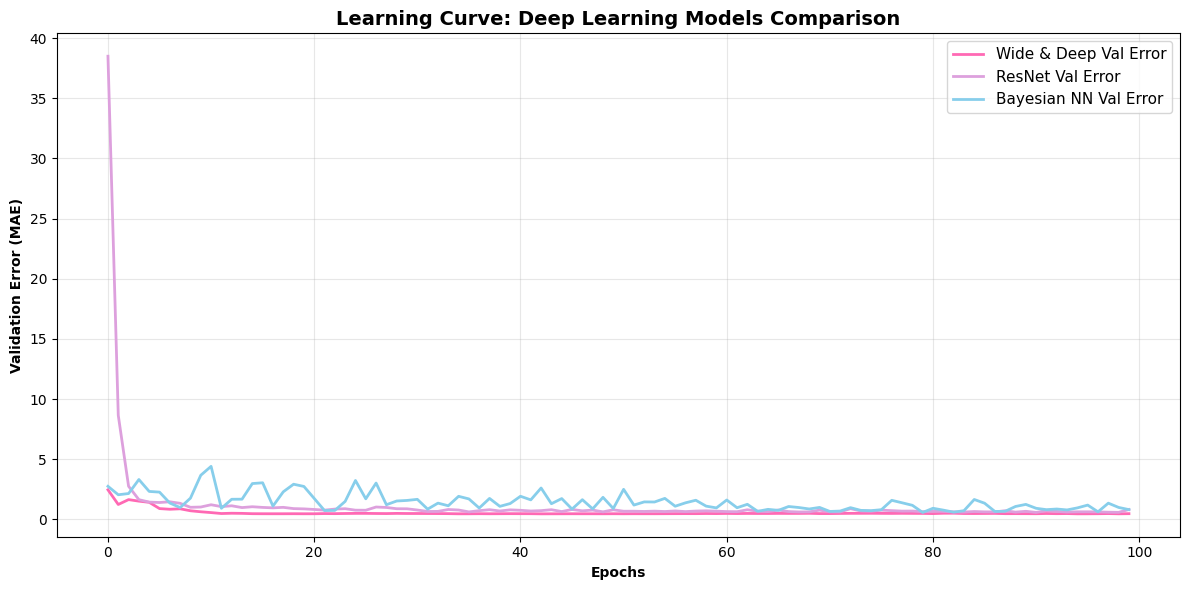

In [154]:
plt.figure(figsize=(12, 6))
plt.plot(history_wd.history['val_mae'], label='Wide & Deep Val Error', color='#FF69B4', linewidth=2)
plt.plot(history_resnet.history['val_mae'], label='ResNet Val Error', color='#DDA0DD', linewidth=2)
plt.plot(history_bayesian.history['val_mae'], label='Bayesian NN Val Error', color='#87CEEB', linewidth=2)
plt.title('Learning Curve: Deep Learning Models Comparison', fontweight='bold', fontsize=14)
plt.ylabel('Validation Error (MAE)', fontweight='bold')
plt.xlabel('Epochs', fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Complete Deep Learning Models Comparison
Comparing the 3 deep learning architectures

COMPLETE DEEP LEARNING MODELS COMPARISON
         Model     MAE      R²  Accuracy (%)
0  Wide & Deep  0.4981  0.7623       99.4705
1  Bayesian NN  0.8127  0.7252       98.4115
2       ResNet  0.8226  0.7158       98.2602


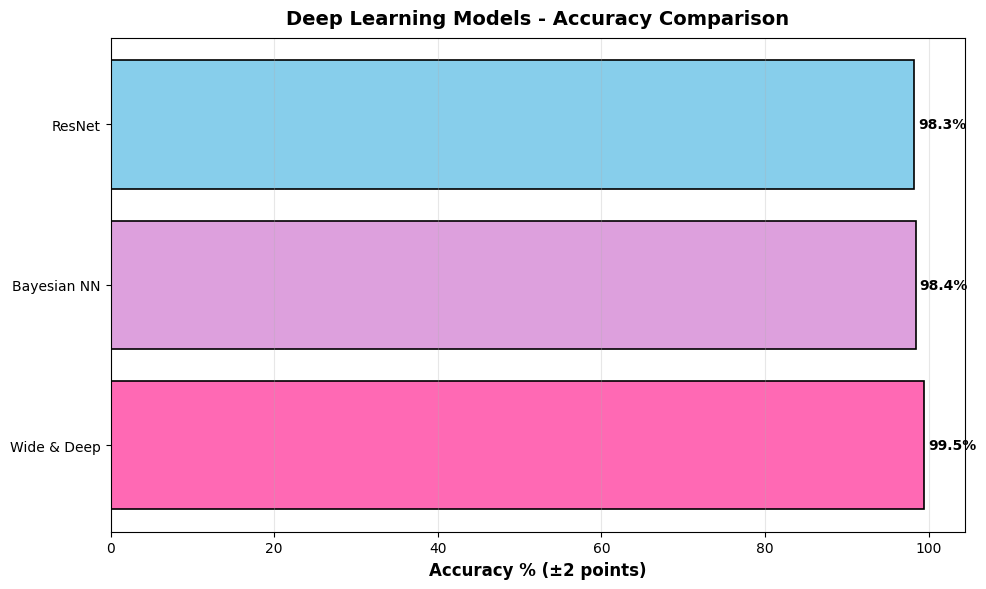


📊 KEY INSIGHTS:
🎪 Best Model (Accuracy): Wide & Deep with 99.5%
📉 Lowest Accuracy: ResNet with 98.3%

💡 Accuracy range: 1.2 percentage points difference between best and worst model


In [155]:
# Compile all deep learning model results
dl_comparison = pd.DataFrame({
    'Model': [
        'Wide & Deep',
        'ResNet',
        'Bayesian NN'
    ],
    'MAE': [
        mae_wd,
        mae_res,
        mae_bayesian
    ],
    'R²': [
        r2_wd,
        r2_res,
        r2_bayesian
    ],
    'Accuracy (%)': [
        np.mean(np.abs(y_test - pred_wd.flatten()) <= 2) * 100,
        accuracy_res,
        accuracy_bayesian
    ]
})

# Sort by R² score
dl_comparison = dl_comparison.sort_values('R²', ascending=False).reset_index(drop=True)

print("="*80)
print("COMPLETE DEEP LEARNING MODELS COMPARISON")
print("="*80)
print(dl_comparison.round(4))
print("="*80)

# Create visualization
plt.figure(figsize=(10, 6))

# Color palette
dl_colors = ['#FF69B4', '#DDA0DD', '#87CEEB']

# Accuracy Comparison
plt.barh(dl_comparison['Model'], dl_comparison['Accuracy (%)'], 
        color=dl_colors, edgecolor='black', linewidth=1.2)
plt.xlabel('Accuracy % (±2 points)', fontweight='bold', fontsize=12)
plt.title('Deep Learning Models - Accuracy Comparison', fontweight='bold', fontsize=14, pad=10)
plt.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(dl_comparison.iterrows()):
    plt.text(row['Accuracy (%)'] + 0.5, i, f"{row['Accuracy (%)']:.1f}%", 
            va='center', ha='left', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('12_complete_dl_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print insights
print("\n📊 KEY INSIGHTS:")
print(f"🎪 Best Model (Accuracy): {dl_comparison.loc[dl_comparison['Accuracy (%)'].idxmax()]['Model']} with {dl_comparison['Accuracy (%)'].max():.1f}%")
print(f"📉 Lowest Accuracy: {dl_comparison.loc[dl_comparison['Accuracy (%)'].idxmin()]['Model']} with {dl_comparison['Accuracy (%)'].min():.1f}%")

best_acc = dl_comparison['Accuracy (%)'].max()
worst_acc = dl_comparison['Accuracy (%)'].min()
diff = best_acc - worst_acc
print(f"\n💡 Accuracy range: {diff:.1f} percentage points difference between best and worst model")

# Deep Learning vs Traditional ML - Final Comparison


ULTIMATE COMPARISON: TRADITIONAL ML vs DEEP LEARNING
               Model            Type       MAE
0   Wide & Deep (DL)   Deep Learning  0.498146
1                SVR  Traditional ML  0.560420
2   Bayesian NN (DL)   Deep Learning  0.812706
3        ResNet (DL)   Deep Learning  0.822646
4  Gradient Boosting  Traditional ML  0.823786
5  Linear Regression  Traditional ML  1.015673


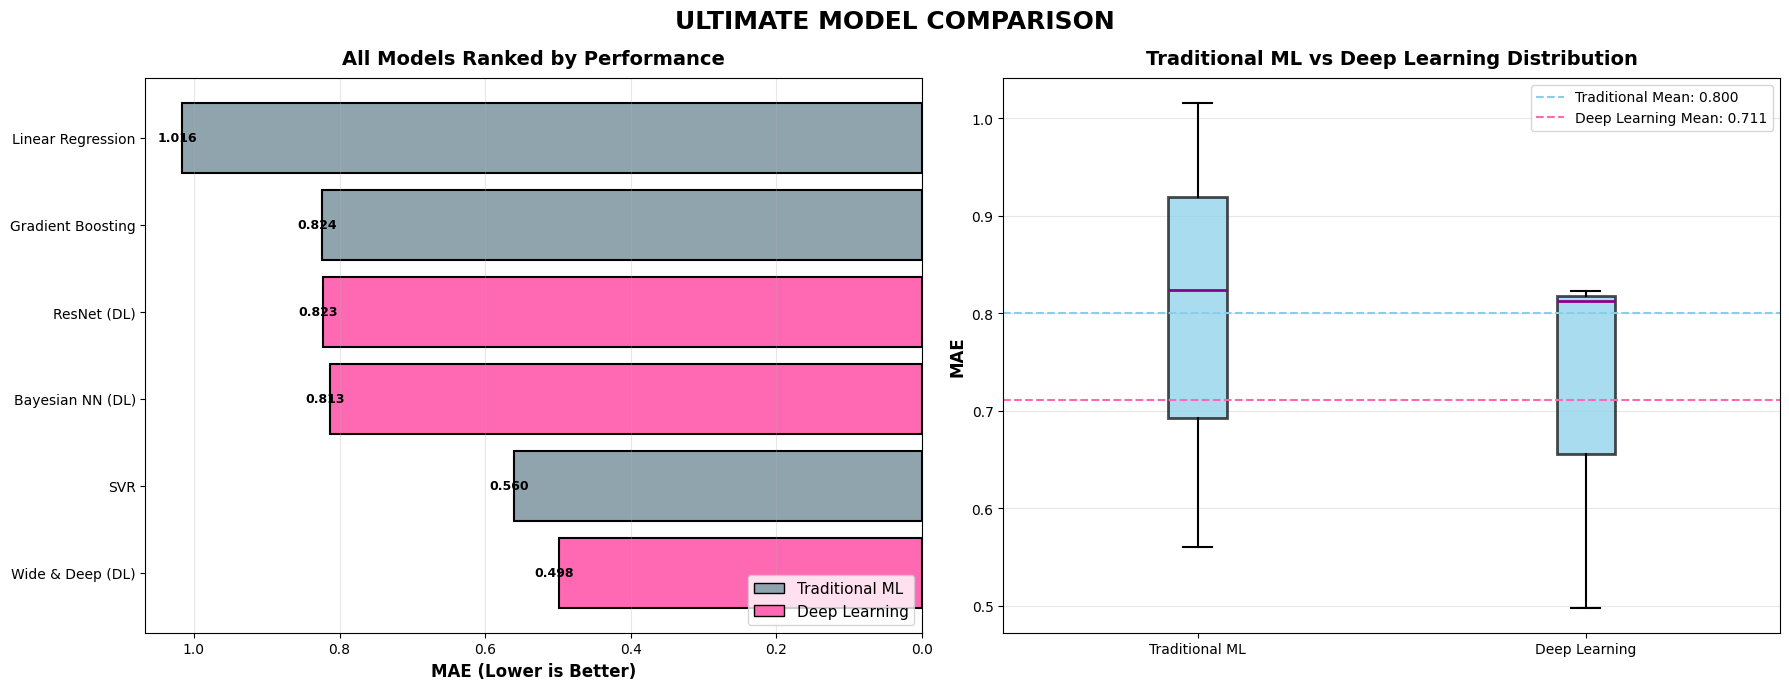


📊 FINAL STATISTICS:

Traditional ML Models:
  Average MAE: 0.8000
  Best MAE: 0.5604 (SVR)
  Worst MAE: 1.0157 (Linear Regression)

Deep Learning Models:
  Average MAE: 0.7112
  Best MAE: 0.4981 (Wide & Deep (DL))
  Worst MAE: 0.8226 (ResNet (DL))

🎯 Deep Learning improved average MAE by 11.10% compared to Traditional ML

🏆 OVERALL WINNER: Wide & Deep (DL) with MAE = 0.4981


In [156]:
# Create final comparison: Traditional ML vs Deep Learning
final_comparison = pd.DataFrame({
    'Model': [
        'Linear Regression',
        'SVR',
        'Gradient Boosting',
        'Wide & Deep (DL)',
        'ResNet (DL)',
        'Bayesian NN (DL)'
    ],
    'Type': [
        'Traditional ML', 'Traditional ML', 'Traditional ML',
        'Deep Learning', 'Deep Learning', 'Deep Learning'
    ],
    'MAE': [
        model_results['Linear Regression']['MAE'],
        model_results['SVR']['MAE'],
        model_results['Gradient Boosting']['MAE'],
        mae_wd,
        mae_res,
        mae_bayesian
    ]
})

# Sort by MAE
final_comparison = final_comparison.sort_values('MAE').reset_index(drop=True)

print("\n" + "="*80)
print("ULTIMATE COMPARISON: TRADITIONAL ML vs DEEP LEARNING")
print("="*80)
print(final_comparison)
print("="*80)

# Visualize Traditional ML vs Deep Learning
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Split by type
traditional_ml = final_comparison[final_comparison['Type'] == 'Traditional ML']
deep_learning = final_comparison[final_comparison['Type'] == 'Deep Learning']

# Left: Bar chart comparison
all_models = final_comparison['Model'].values
all_maes = final_comparison['MAE'].values
colors_final = ['#90A4AE' if t == 'Traditional ML' else '#FF69B4' 
                for t in final_comparison['Type']]

axes[0].barh(range(len(all_models)), all_maes, color=colors_final, 
            edgecolor='black', linewidth=1.5)
axes[0].set_yticks(range(len(all_models)))
axes[0].set_yticklabels(all_models, fontsize=10)
axes[0].set_xlabel('MAE (Lower is Better)', fontweight='bold', fontsize=12)
axes[0].set_title('All Models Ranked by Performance', fontweight='bold', fontsize=14, pad=10)
axes[0].invert_xaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#90A4AE', edgecolor='black', label='Traditional ML'),
    Patch(facecolor='#FF69B4', edgecolor='black', label='Deep Learning')
]
axes[0].legend(handles=legend_elements, loc='lower right', fontsize=11)

# Add value labels
for i, mae in enumerate(all_maes):
    axes[0].text(mae - 0.02, i, f'{mae:.3f}', 
                va='center', ha='right', fontweight='bold', fontsize=9)

# Right: Box plot comparison
axes[1].boxplot([traditional_ml['MAE'].values, deep_learning['MAE'].values],
               labels=['Traditional ML', 'Deep Learning'],
               patch_artist=True,
               boxprops=dict(facecolor='#87CEEB', alpha=0.7, edgecolor='black', linewidth=2),
               medianprops=dict(color='#8B008B', linewidth=2),
               whiskerprops=dict(color='black', linewidth=1.5),
               capprops=dict(color='black', linewidth=1.5))

axes[1].set_ylabel('MAE', fontweight='bold', fontsize=12)
axes[1].set_title('Traditional ML vs Deep Learning Distribution', fontweight='bold', fontsize=14, pad=10)
axes[1].grid(True, alpha=0.3, axis='y')

# Add statistics
trad_mean = traditional_ml['MAE'].mean()
dl_mean = deep_learning['MAE'].mean()
axes[1].axhline(y=trad_mean, color='#87CEEB', linestyle='--', linewidth=1.5, 
               label=f'Traditional Mean: {trad_mean:.3f}')
axes[1].axhline(y=dl_mean, color='#FF69B4', linestyle='--', linewidth=1.5,
               label=f'Deep Learning Mean: {dl_mean:.3f}')
axes[1].legend(fontsize=10)

plt.suptitle('ULTIMATE MODEL COMPARISON', 
            fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('13_ultimate_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Final statistics
print("\n📊 FINAL STATISTICS:")
print(f"\nTraditional ML Models:")
print(f"  Average MAE: {trad_mean:.4f}")
print(f"  Best MAE: {traditional_ml['MAE'].min():.4f} ({traditional_ml.loc[traditional_ml['MAE'].idxmin(), 'Model']})")
print(f"  Worst MAE: {traditional_ml['MAE'].max():.4f} ({traditional_ml.loc[traditional_ml['MAE'].idxmax(), 'Model']})")

print(f"\nDeep Learning Models:")
print(f"  Average MAE: {dl_mean:.4f}")
print(f"  Best MAE: {deep_learning['MAE'].min():.4f} ({deep_learning.loc[deep_learning['MAE'].idxmin(), 'Model']})")
print(f"  Worst MAE: {deep_learning['MAE'].max():.4f} ({deep_learning.loc[deep_learning['MAE'].idxmax(), 'Model']})")

improvement_pct = ((trad_mean - dl_mean) / trad_mean) * 100
if improvement_pct > 0:
    print(f"\n🎯 Deep Learning improved average MAE by {improvement_pct:.2f}% compared to Traditional ML")
else:
    print(f"\n📊 Traditional ML has {-improvement_pct:.2f}% better average MAE compared to Deep Learning")

print(f"\n🏆 OVERALL WINNER: {final_comparison.iloc[0]['Model']} with MAE = {final_comparison.iloc[0]['MAE']:.4f}")

# Deep Learning vs Traditional ML - Accuracy Comparison


ULTIMATE COMPARISON: TRADITIONAL ML vs DEEP LEARNING (ACCURACY)
               Model            Type  Accuracy (%)
0   Wide & Deep (DL)   Deep Learning     99.470499
1                SVR  Traditional ML     99.092284
2   Bayesian NN (DL)   Deep Learning     98.411498
3        ResNet (DL)   Deep Learning     98.260212
4  Gradient Boosting  Traditional ML     95.763994
5  Linear Regression  Traditional ML     92.057489


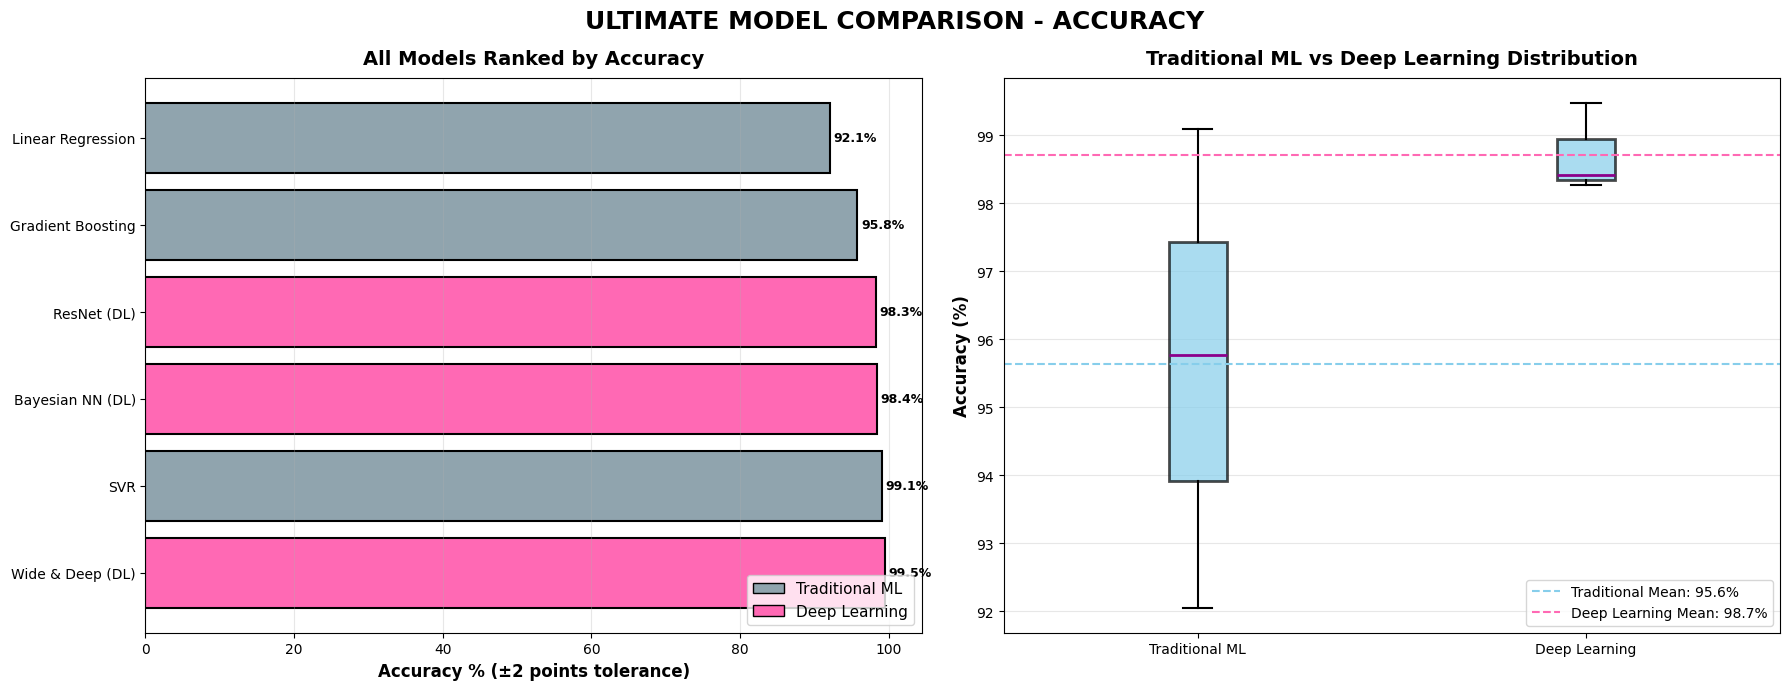


📊 ACCURACY STATISTICS:

Traditional ML Models:
  Average Accuracy: 95.64%
  Best Accuracy: 99.09% (SVR)
  Worst Accuracy: 92.06% (Linear Regression)

Deep Learning Models:
  Average Accuracy: 98.71%
  Best Accuracy: 99.47% (Wide & Deep (DL))
  Worst Accuracy: 98.26% (ResNet (DL))

🎯 Deep Learning achieved 3.08 percentage points higher accuracy compared to Traditional ML

🏆 OVERALL WINNER (ACCURACY): Wide & Deep (DL) with 99.47% accuracy


In [157]:
# Create accuracy-based comparison: Traditional ML vs Deep Learning
accuracy_comparison = pd.DataFrame({
    'Model': [
        'Linear Regression',
        'SVR',
        'Gradient Boosting',
        'Wide & Deep (DL)',
        'ResNet (DL)',
        'Bayesian NN (DL)'
    ],
    'Type': [
        'Traditional ML', 'Traditional ML', 'Traditional ML',
        'Deep Learning', 'Deep Learning', 'Deep Learning'
    ],
    'Accuracy (%)': [
        model_results['Linear Regression']['Accuracy'],
        model_results['SVR']['Accuracy'],
        model_results['Gradient Boosting']['Accuracy'],
        np.mean(np.abs(y_test - pred_wd.flatten()) <= 2) * 100,
        accuracy_res,
        accuracy_bayesian
    ]
})

# Sort by Accuracy (descending)
accuracy_comparison = accuracy_comparison.sort_values('Accuracy (%)', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("ULTIMATE COMPARISON: TRADITIONAL ML vs DEEP LEARNING (ACCURACY)")
print("="*80)
print(accuracy_comparison)
print("="*80)

# Visualize Traditional ML vs Deep Learning by Accuracy
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Split by type
traditional_ml_acc = accuracy_comparison[accuracy_comparison['Type'] == 'Traditional ML']
deep_learning_acc = accuracy_comparison[accuracy_comparison['Type'] == 'Deep Learning']

# Left: Bar chart comparison
all_models_acc = accuracy_comparison['Model'].values
all_accuracies = accuracy_comparison['Accuracy (%)'].values
colors_acc = ['#90A4AE' if t == 'Traditional ML' else '#FF69B4' 
              for t in accuracy_comparison['Type']]

axes[0].barh(range(len(all_models_acc)), all_accuracies, color=colors_acc, 
            edgecolor='black', linewidth=1.5)
axes[0].set_yticks(range(len(all_models_acc)))
axes[0].set_yticklabels(all_models_acc, fontsize=10)
axes[0].set_xlabel('Accuracy % (±2 points tolerance)', fontweight='bold', fontsize=12)
axes[0].set_title('All Models Ranked by Accuracy', fontweight='bold', fontsize=14, pad=10)
axes[0].grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#90A4AE', edgecolor='black', label='Traditional ML'),
    Patch(facecolor='#FF69B4', edgecolor='black', label='Deep Learning')
]
axes[0].legend(handles=legend_elements, loc='lower right', fontsize=11)

# Add value labels
for i, acc in enumerate(all_accuracies):
    axes[0].text(acc + 0.5, i, f'{acc:.1f}%', 
                va='center', ha='left', fontweight='bold', fontsize=9)

# Right: Box plot comparison
axes[1].boxplot([traditional_ml_acc['Accuracy (%)'].values, deep_learning_acc['Accuracy (%)'].values],
               labels=['Traditional ML', 'Deep Learning'],
               patch_artist=True,
               boxprops=dict(facecolor='#87CEEB', alpha=0.7, edgecolor='black', linewidth=2),
               medianprops=dict(color='#8B008B', linewidth=2),
               whiskerprops=dict(color='black', linewidth=1.5),
               capprops=dict(color='black', linewidth=1.5))

axes[1].set_ylabel('Accuracy (%)', fontweight='bold', fontsize=12)
axes[1].set_title('Traditional ML vs Deep Learning Distribution', fontweight='bold', fontsize=14, pad=10)
axes[1].grid(True, alpha=0.3, axis='y')

# Add statistics
trad_mean_acc = traditional_ml_acc['Accuracy (%)'].mean()
dl_mean_acc = deep_learning_acc['Accuracy (%)'].mean()
axes[1].axhline(y=trad_mean_acc, color='#87CEEB', linestyle='--', linewidth=1.5, 
               label=f'Traditional Mean: {trad_mean_acc:.1f}%')
axes[1].axhline(y=dl_mean_acc, color='#FF69B4', linestyle='--', linewidth=1.5,
               label=f'Deep Learning Mean: {dl_mean_acc:.1f}%')
axes[1].legend(fontsize=10)

plt.suptitle('ULTIMATE MODEL COMPARISON - ACCURACY', 
            fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('14_ultimate_comparison_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# Final statistics
print("\n📊 ACCURACY STATISTICS:")
print(f"\nTraditional ML Models:")
print(f"  Average Accuracy: {trad_mean_acc:.2f}%")
print(f"  Best Accuracy: {traditional_ml_acc['Accuracy (%)'].max():.2f}% ({traditional_ml_acc.loc[traditional_ml_acc['Accuracy (%)'].idxmax(), 'Model']})")
print(f"  Worst Accuracy: {traditional_ml_acc['Accuracy (%)'].min():.2f}% ({traditional_ml_acc.loc[traditional_ml_acc['Accuracy (%)'].idxmin(), 'Model']})")

print(f"\nDeep Learning Models:")
print(f"  Average Accuracy: {dl_mean_acc:.2f}%")
print(f"  Best Accuracy: {deep_learning_acc['Accuracy (%)'].max():.2f}% ({deep_learning_acc.loc[deep_learning_acc['Accuracy (%)'].idxmax(), 'Model']})")
print(f"  Worst Accuracy: {deep_learning_acc['Accuracy (%)'].min():.2f}% ({deep_learning_acc.loc[deep_learning_acc['Accuracy (%)'].idxmin(), 'Model']})")

improvement_pct_acc = dl_mean_acc - trad_mean_acc
if improvement_pct_acc > 0:
    print(f"\n🎯 Deep Learning achieved {improvement_pct_acc:.2f} percentage points higher accuracy compared to Traditional ML")
else:
    print(f"\n📊 Traditional ML has {-improvement_pct_acc:.2f} percentage points higher accuracy compared to Deep Learning")

print(f"\n🏆 OVERALL WINNER (ACCURACY): {accuracy_comparison.iloc[0]['Model']} with {accuracy_comparison.iloc[0]['Accuracy (%)']:.2f}% accuracy")